# Set up

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import warnings
import lightgbm as lgb

# Charge et préparation des données
df = pd.read_csv("metadonnees avec delta.csv")
X = df.drop(columns=["patient", "group", "therapy", "delta_THI"])
y = df["delta_THI"]

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Désactivation des warnings CatBoost
warnings.filterwarnings("ignore")

# Initialisation de tous les modèles
models = {
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "k-NN Regressor": KNeighborsRegressor(n_neighbors=5),
    "SVR (RBF kernel)": SVR(kernel='rbf', C=1.0, epsilon=0.2),
    "LightGBM Regressor": lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost Regressor": xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "Neural Network Regressor": MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500, random_state=42),
    # Suppression du Gaussian Process Regressor car cause d'outlayer importante avec des résultats désastreux
    #"Gaussian Process Regressor": GaussianProcessRegressor(kernel=C(1.0) * RBF(length_scale=1.0), random_state=42),
    "Voting Regressor": VotingRegressor(estimators=[
        ('ridge', Ridge(alpha=1.0)),
        ('svr', SVR(kernel='rbf')),
        ('knn', KNeighborsRegressor(n_neighbors=5))
    ])
}

# Entraînement

In [ ]:
# Dictionnaire pour stocker les scores
results = {
    "Modèle": [],
    "MSE": [],
    "R²": []
}

# Boucle d'entraînement
for name, model in models.items():
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results["Modèle"].append(name)
        results["MSE"].append(mse)
        results["R²"].append(r2)

        print(f"\n{name} :")
        print(f" - MSE : {mse:.2f}")
        print(f" - R² : {r2:.2f}")
    except Exception as e:
        print(f"\n{name} - Erreur : {str(e)}")

# Conversion en dataframe
df_results = pd.DataFrame(results).sort_values(by="MSE")


Ridge Regression :
 - MSE : 11.61
 - R² : 0.01

Lasso Regression :
 - MSE : 13.02
 - R² : -0.11

k-NN Regressor :
 - MSE : 9.73
 - R² : 0.17

SVR (RBF kernel) :
 - MSE : 12.38
 - R² : -0.06

LightGBM Regressor :
 - MSE : 24.32
 - R² : -1.08

Random Forest Regressor :
 - MSE : 19.07
 - R² : -0.63

XGBoost Regressor :
 - MSE : 33.16
 - R² : -1.83

Neural Network Regressor :
 - MSE : 13.08
 - R² : -0.12

Voting Regressor :
 - MSE : 10.48
 - R² : 0.11


# Visualisation

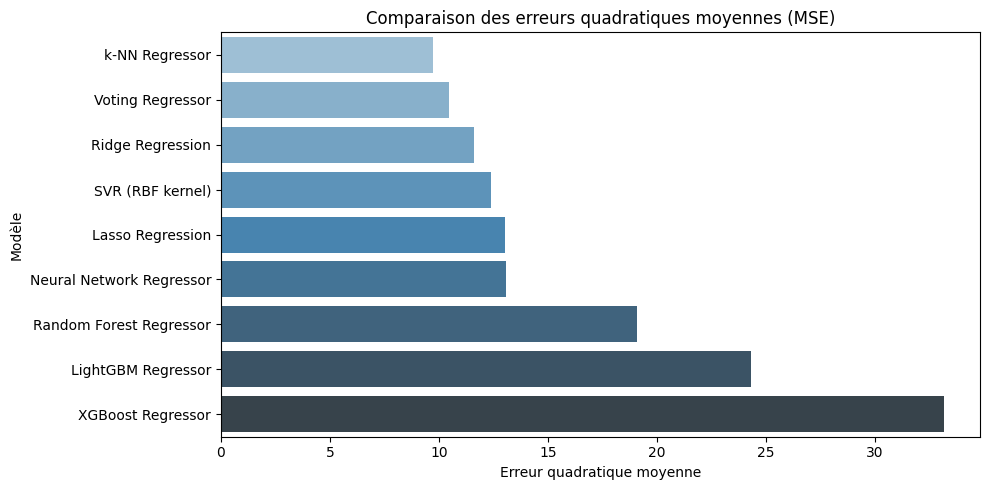

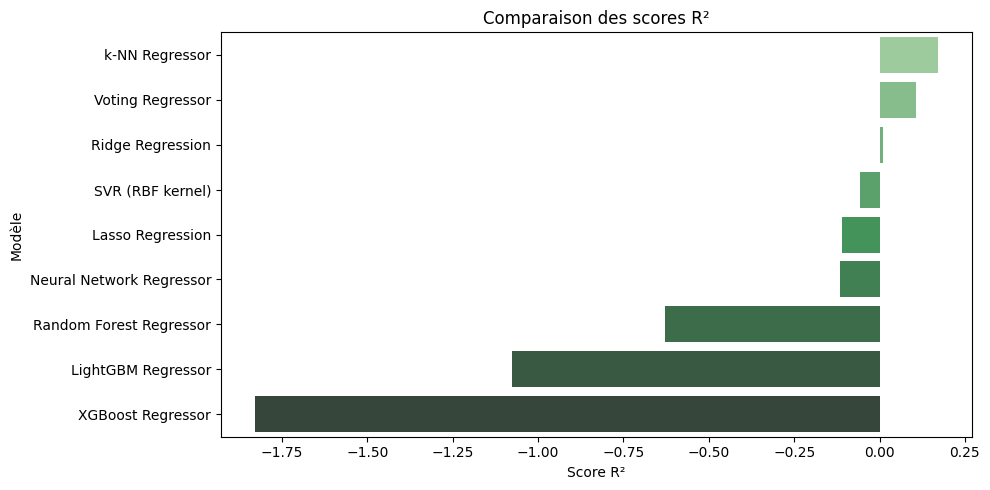

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisation des MSE
plt.figure(figsize=(10, 5))
sns.barplot(data=df_results, x="MSE", y="Modèle", palette="Blues_d")
plt.title("Comparaison des erreurs quadratiques moyennes (MSE)")
plt.xlabel("Erreur quadratique moyenne")
plt.ylabel("Modèle")
plt.tight_layout()
plt.show()

# Visualisation des scores R²
plt.figure(figsize=(10, 5))
sns.barplot(data=df_results, x="R²", y="Modèle", palette="Greens_d")
plt.title("Comparaison des scores R²")
plt.xlabel("Score R²")
plt.ylabel("Modèle")
plt.tight_layout()
plt.show()

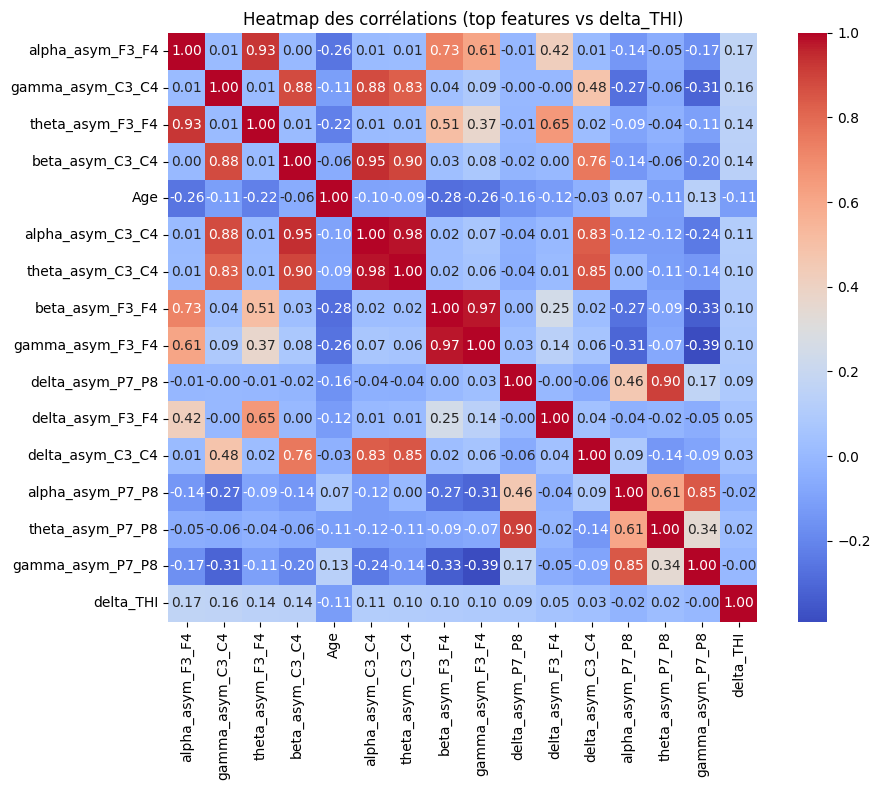

In [ ]:
# Heatmap de corrélation avec delta_THI
corr_matrix = df.corr(numeric_only=True)

# Tri des corrélations avec la cible
target_corr = corr_matrix["delta_THI"].drop("delta_THI").sort_values(key=abs, ascending=False)

# Sélection des plus corrélées (par exemple top 15)
top_features = target_corr.head(15).index.tolist() + ["delta_THI"]

plt.figure(figsize=(10, 8))
sns.heatmap(df[top_features].corr(), annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Heatmap des corrélations (top features vs delta_THI)")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler

# === Données ===
df = pd.read_csv("metadonnees avec delta.csv")
X = df.drop(columns=["patient", "group", "therapy", "delta_THI"])
y = df["delta_THI"]

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Split (pas strictement nécessaire ici, mais utile si on veut un modèle général)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 1. Sélection par corrélation ===
corrs = df.corr(numeric_only=True)["delta_THI"].drop("delta_THI")
threshold = 0.15
features_corr = corrs[abs(corrs) >= threshold].index.tolist()

# === 2. Sélection par importance Random Forest ===
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
top_percent = 0.2  # Top 20%
top_n = int(len(importances) * top_percent)
features_rf = importances.head(top_n).index.tolist()

# === 3. Comparaison ===
common_features = set(features_corr).intersection(set(features_rf))
only_corr = set(features_corr) - set(features_rf)
only_rf = set(features_rf) - set(features_corr)

# === 4. Résumé ===
print("\nRésumé de la sélection de features :\n")
print(f"• Features sélectionnées par corrélation (|r| ≥ {threshold}) : {len(features_corr)}")
print(f"• Features sélectionnées par importance (top {int(top_percent*100)}%) : {len(features_rf)}")
print(f"• En commun : {len(common_features)}\n")

print("Features communes :", sorted(common_features))
print("\nSeulement par corrélation :", sorted(only_corr))
print("\nSeulement par Random Forest :", sorted(only_rf))


Résumé de la sélection de features :

• Features sélectionnées par corrélation (|r| ≥ 0.15) : 2
• Features sélectionnées par importance (top 20%) : 3
• En commun : 0

Features communes : []

Seulement par corrélation : ['alpha_asym_F3_F4', 'gamma_asym_C3_C4']

Seulement par Random Forest : ['delta_asym_F3_F4', 'gamma_asym_F3_F4', 'gamma_asym_P7_P8']


In [ ]:
!pip install shap


SHAP pour Random Forest Regressor


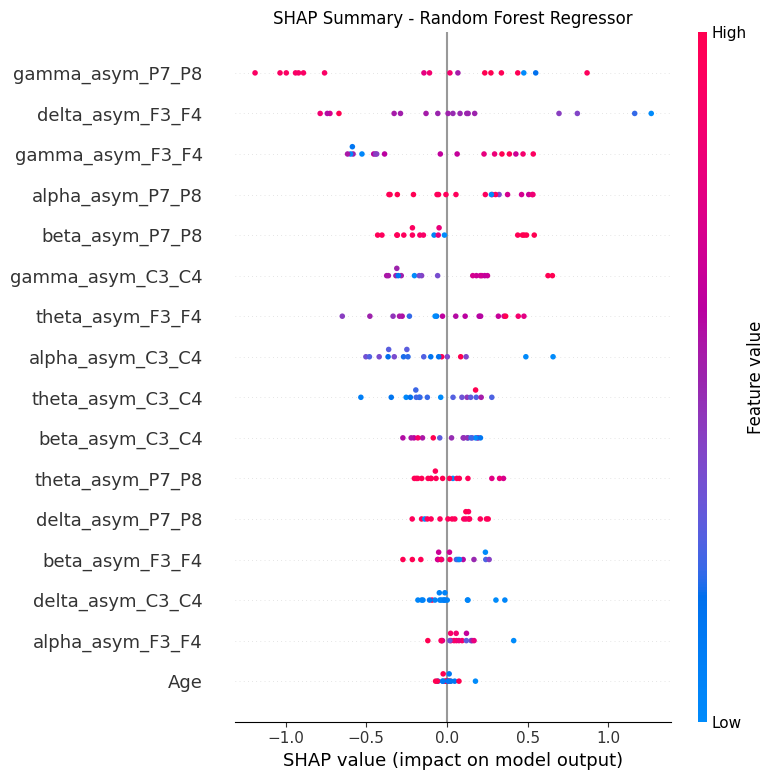

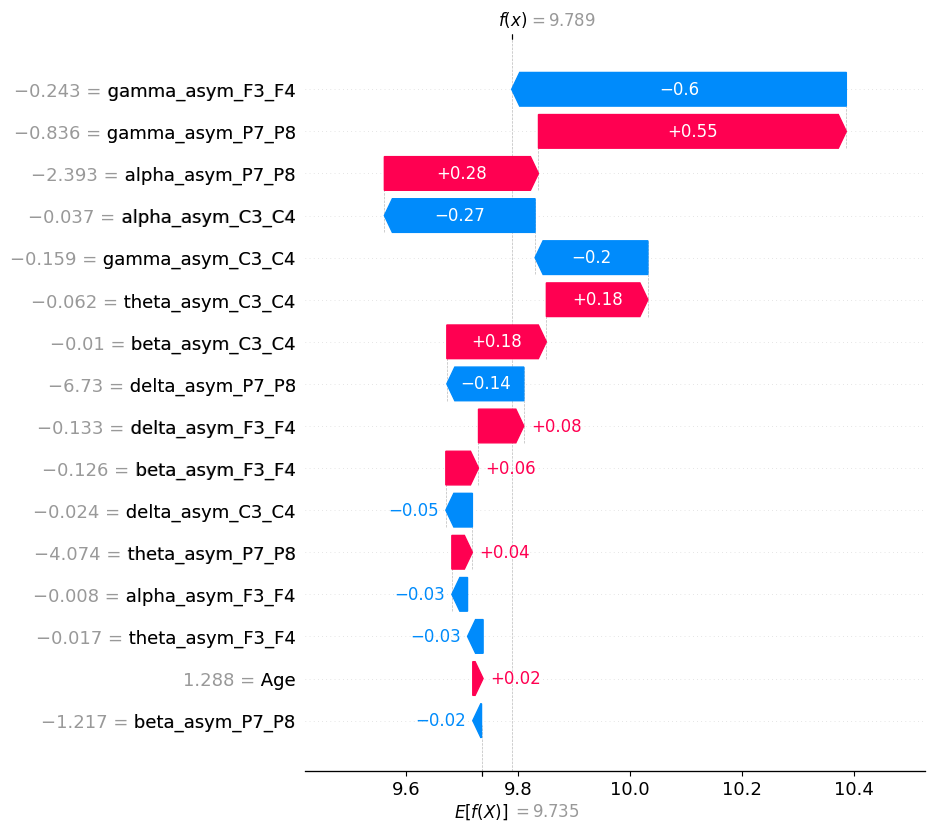


SHAP pour XGBoost Regressor


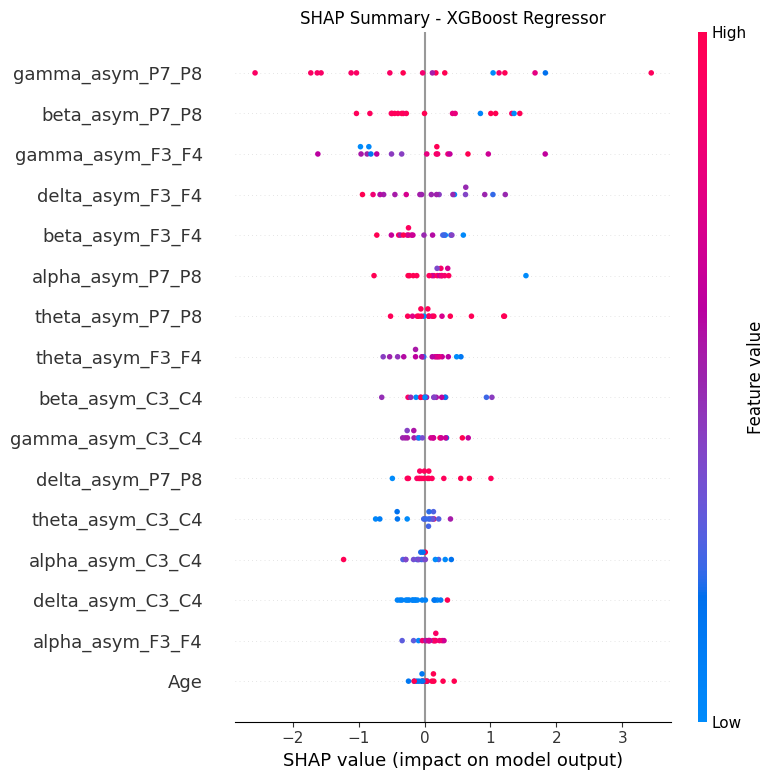

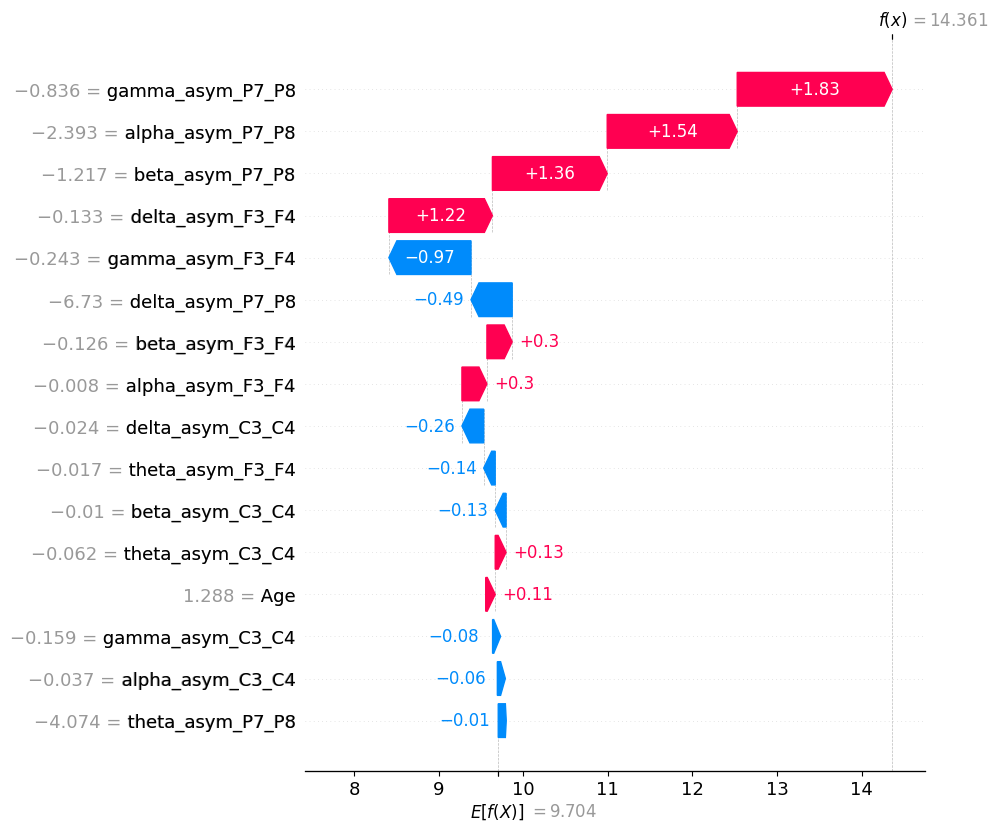


SHAP pour LightGBM Regressor


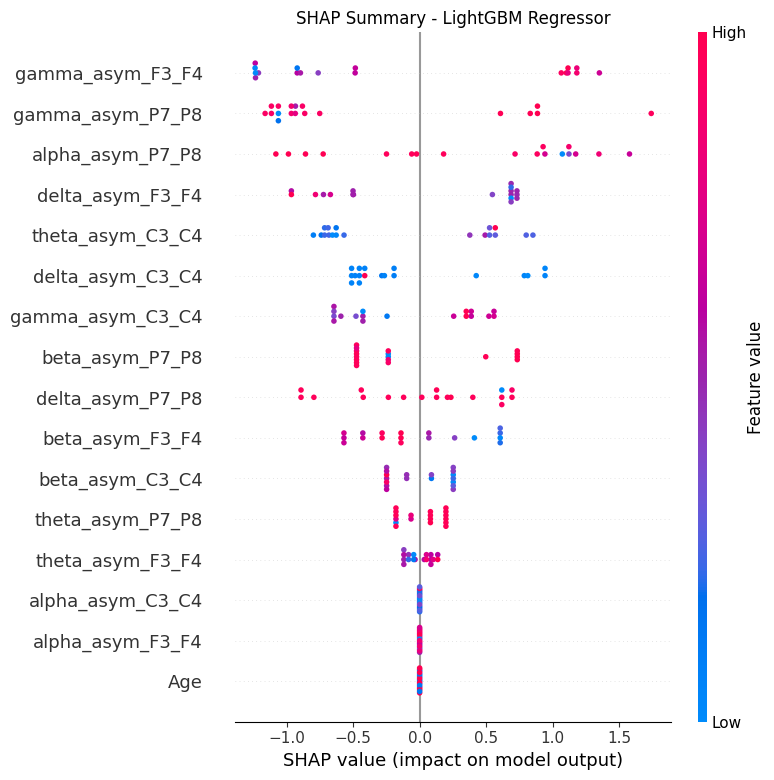

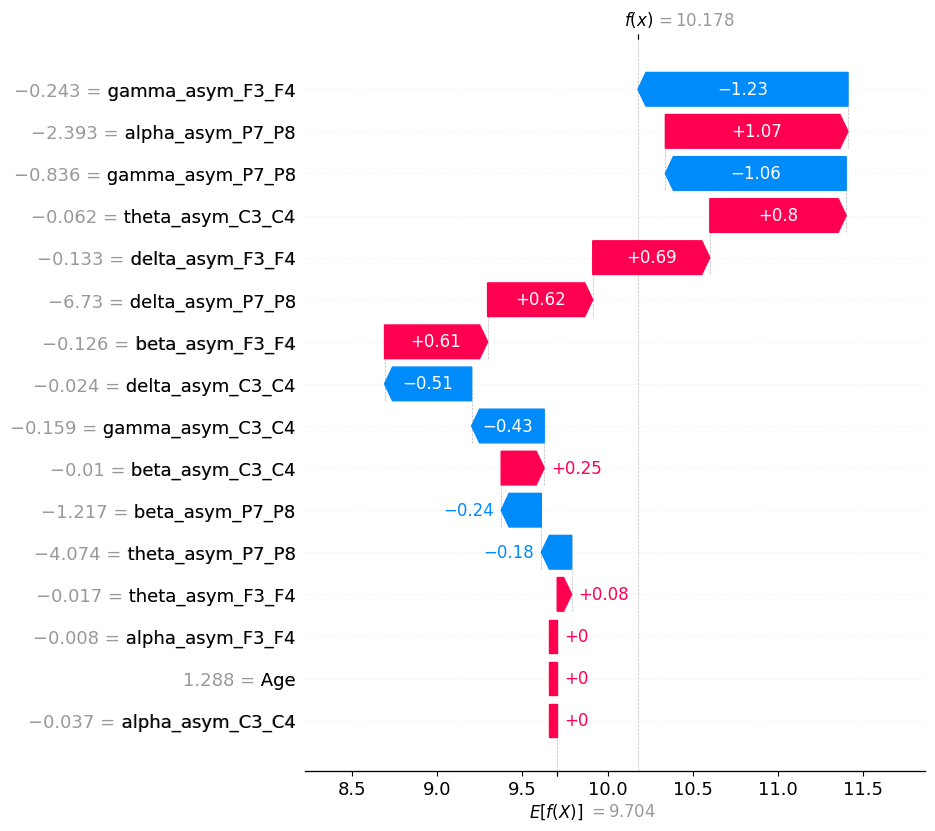


SHAP pour Ridge Regression


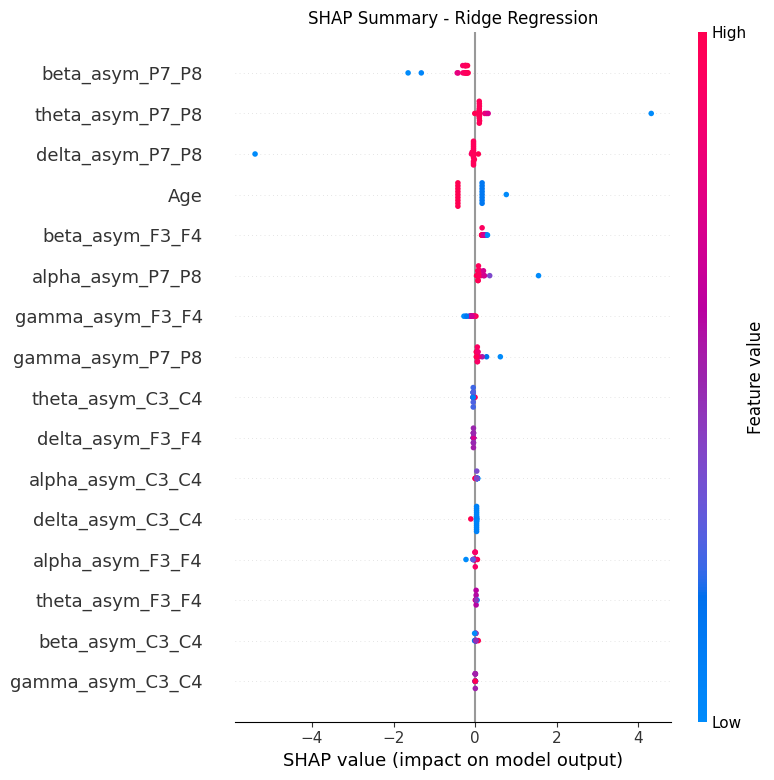

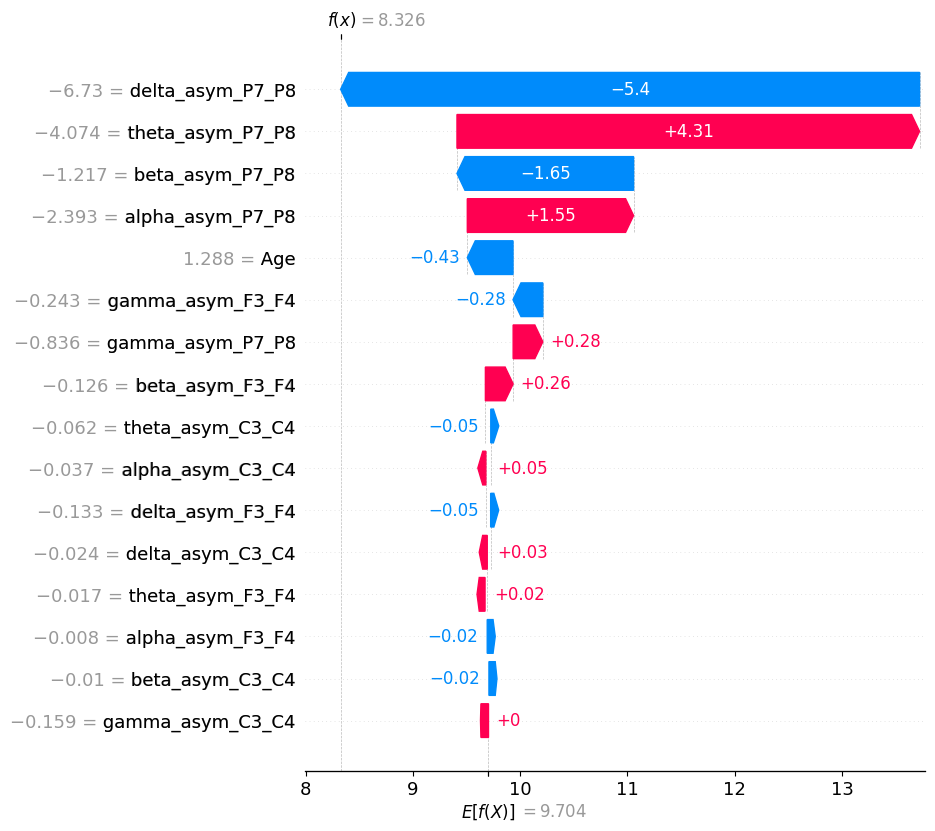

In [ ]:
# Liste des modèles compatibles SHAP
shap_compatibles = {
    "Random Forest Regressor": models["Random Forest Regressor"],
    "XGBoost Regressor": models["XGBoost Regressor"],
    "LightGBM Regressor": models["LightGBM Regressor"],
    "Ridge Regression": models["Ridge Regression"]  # SHAP KernelExplainer si linéaire
}

# Entraînement de chaque modèle sur le jeu complet pour une explication globale plus précise
for name, model in shap_compatibles.items():
    try:
        print(f"\nSHAP pour {name}")
        model.fit(X_train, y_train)

        # Création de l’explainer selon le type de modèle
        if "XGB" in name or "LightGBM" in name or "Random Forest" in name:
            explainer = shap.Explainer(model, X_train)
        else:
            explainer = shap.Explainer(model.predict, X_train)

        shap_values = explainer(X_test)

        # Summary plot (global) avec taille réduite
        plt.figure(figsize=(4, 2))
        shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
        plt.title(f"SHAP Summary - {name}")
        plt.tight_layout()
        plt.show()

        # Waterfall plot (local) sur la première prédiction
        shap.plots.waterfall(shap_values[0], max_display=16)
    except Exception as e:
        print(f"Erreur SHAP avec {name} : {e}")
